## LSTM for Short-Term XRP Price Forecasting

Cryptocurrency price data exhibits nonlinear, nonstationary, and highly temporal dynamics. These characteristics make traditional regression models inadequate for accurate short-term forecasting. Recurrent neural networks (RNNs), particularly **Long Short-Term Memory (LSTM)** networks, are designed to capture sequential dependencies within time series by maintaining a form of "memory" over prior observations.  

LSTMs mitigate the vanishing gradient problem of standard RNNs through gated mechanisms that control how information is retained or forgotten across timesteps. This makes them especially well suited for modeling price sequences, where current market movements are strongly influenced by the preceding trend, volatility, and momentum.  

In this notebook, we construct and evaluate an LSTM model to predict the **next hourly closing price of XRP (USD)** using features derived from historical price and return data collected through **September 30, 2025**. The model is trained using **walk-forward validation** to mimic realistic forecasting conditions and is compared against a baseline **buy-and-hold strategy** for interpretability and performance benchmarking.

In [2]:
# ========== Core Libraries ==========
import random
import numpy as np
import pandas as pd

# ========== Visualization ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== Preprocessing & Evaluation ==========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ========== Deep Learning (TensorFlow/Keras) ==========
import tensorflow as tf
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ========== Reproducibility ==========
random.seed(12)
np.random.seed(12)
tf.random.set_seed(12)

### Load and Resample XRP Data

We begin by importing the raw XRP price dataset, which contains high-frequency trading data at one-minute intervals, including open, high, low, close, volume, and other related metrics. To make the series more interpertable and reduce short-term noise, we resample it to an hourly frequency.

For each hour, we compute the following aggregates:

- **Open:** the first price of the hour  
- **High:** the maximum price within the hour  
- **Low:** the minimum price within the hour  
- **Close:** the final price of the hour  
- **Volume:** the total traded volume over the hour  
- **Quote asset volume, number of trades, taker buy volumes, etc.:** summed over the hour  

This resampling provides a more manageable and informative representation of the market's behavior, preserving key structure while reducing computational load.

Visualizing the resampled closing prices allows us to verify data continuity and inspect general trends in the time series.

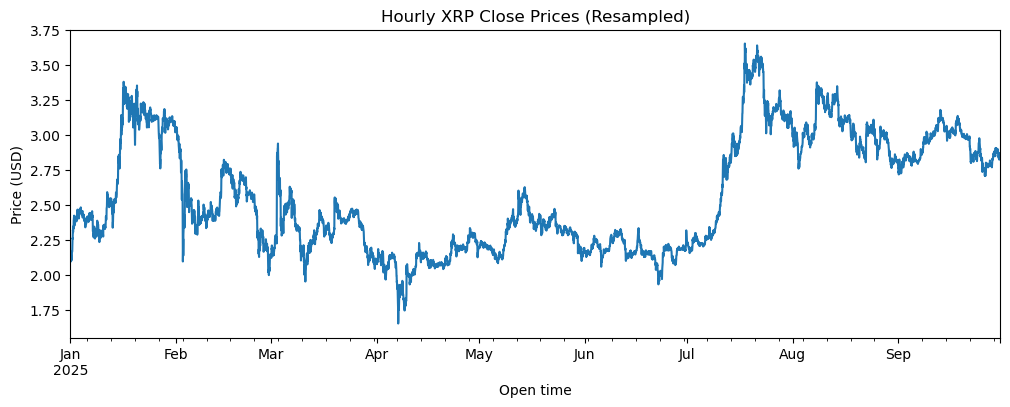

In [4]:
# Read the raw dataset of XRP price history (2025) and parse timestamps
df = pd.read_csv("xrpdata_2025.csv", parse_dates=["Open time"])
df.set_index("Open time", inplace=True)

# Resample all relevant columns from 1-minute data into 1-hour buckets
df_hourly = df.resample("1h").agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    'Quote asset volume': 'sum',
    'Number of trades': 'sum',
    'Taker buy base asset volume': 'sum',
    'Taker buy quote asset volume': 'sum'
}).dropna()

# Visualize the new hourly close to confirm structure
df_hourly['Close'].plot(title="Hourly XRP Close Prices (Resampled)", figsize=(12, 4))
plt.ylabel("Price (USD)")
plt.show()

### Feature Engineering: Lagged and Rolling Features

To better capture temporal dependencies and evolving patterns in XRP price dynamics, we construct a comprehensive set of predictive features from the hourly time series. These include:

- **Lagged closing prices**: values at times \( t-1 \), \( t-2 \), and \( t-3 \) to give the model context from recent price movement.
- **Rolling statistics**: computed over 3-hour and 6-hour windows, including:
  - Mean
  - Standard deviation (volatility)
  - Minimum and maximum values (local range)
- **Target variable**: the current hour’s closing price at time \( t \), which we aim to predict based on prior information.

This expanded feature set helps the model learn both short-term momentum and local volatility regimes, which are important in high-frequency financial forecasting tasks. Any rows with missing values introduced by shifting or rolling operations are removed to maintain a clean dataset for training.

In [6]:
# Create feature DataFrame from hourly closing prices
df_features = pd.DataFrame(index=df_hourly.index)
df_features['Close'] = df_hourly['Close']  # Target variable

# --- Lagged features (recent closing prices) ---
for lag in [1, 2, 3]:
    df_features[f't-{lag}'] = df_hourly['Close'].shift(lag)

# --- Rolling window statistics ---
for window in [3, 6]:
    df_features[f'rolling_mean_{window}'] = df_hourly['Close'].rolling(window=window).mean()
    df_features[f'rolling_std_{window}'] = df_hourly['Close'].rolling(window=window).std()
    df_features[f'rolling_min_{window}'] = df_hourly['Close'].rolling(window=window).min()
    df_features[f'rolling_max_{window}'] = df_hourly['Close'].rolling(window=window).max()

# Drop any rows with missing values caused by shifting/rolling operations
df_features.dropna(inplace=True)

# --- Define feature matrix (X) and target vector (y) ---
feature_columns = [col for col in df_features.columns if col != 'Close']
X = df_features[feature_columns].values
y = df_features['Close'].values

### Train-Test Splitting, Scaling, and Validation Strategy

We begin by dividing the dataset into training and testing subsets using a single chronological split, where the last 20% of observations are held out as a test set. Shuffling is explicitly disabled to preserve the temporal order of the data, an essential practice for realistic time series forecasting.

Feature scaling is performed using standard z-score normalization, applied only to the input features. The scaler is fitted on the training set and then applied to both training and testing sets, ensuring no information from the test set leaks into the training process. The target variable is left unscaled to preserve interpretability, since we are forecasting real-world prices in USD. Although cryptocurrency prices are often volatile, the range of values in this dataset is moderate enough to allow effective learning without transforming the target.

To rigorously assess model performance and mimic real deployment conditions, we implement **walk-forward validation**. In this approach, the model is retrained on an expanding window of historical data and evaluated on the next unseen observation(s). This method closely mirrors how forecasts would be generated in a production environment, where only past data is known at prediction time.

Traditional k-fold cross-validation, though widely used in machine learning, can be inappropriate for time series problems. It introduces the risk of lookahead bias by mixing past and future data during training. Our walk-forward validation strategy maintains strict chronological integrity, offering a more realistic estimate of out-of-sample performance and generalization.

Below, we also define a reusable walk-forward validation loop that accepts a model factory function and iterates through the dataset using an expanding window. Metrics from each iteration: RMSE, MAE, and $ R^2 $, are collected and can be averaged for a comprehensive performance summary.

In [8]:
# Use engineered features
X = df_features[feature_columns].values
y = df_features['Close'].values

# Chronological train-test split (last 20% held out for testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Scale features (fit only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (5237, 11)
Testing set shape: (1310, 11)


### Reshaping Data for LSTM Input

Unlike standard regression models, which treat each observation as independent, recurrent neural networks like LSTMs require input in **sequential form** to learn temporal dependencies. Each training example must represent a short window of consecutive observations, allowing the model to infer patterns that unfold over time.

Here, we define a helper function `create_sequences()` that transforms the 2D feature matrix into overlapping 3D sequences suitable for the LSTM. Each sequence contains the previous 30 hourly observations (features over 30 timesteps), and the corresponding target is the closing price at the next hour.

This reshaping yields input arrays with dimensions:

$$
X \in \mathbb{R}^{(n_{\text{samples}}, \text{seq\_len}, n_{\text{features}})}, \quad
y \in \mathbb{R}^{(n_{\text{samples}})}
$$

where each sample encapsulates a 30-hour history of market behavior. This structure enables the network to recognize momentum, mean reversion, and volatility patterns in sequential form.

Before training, we confirm that our input sequences are correctly shaped for the LSTM.

In [10]:
def create_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

seq_len = 30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, seq_len)

print("Training sequences shape:", X_train_seq.shape)
print("Testing sequences shape:", X_test_seq.shape)

Training sequences shape: (5207, 30, 11)
Testing sequences shape: (1280, 30, 11)


### LSTM Architecture and Training Setup

We now define the Long Short-Term Memory (LSTM) network responsible for learning temporal dependencies in the XRP price data.

The model consists of:
- A single **LSTM layer (32 units)** that captures sequential relationships within each 30-hour input window.
- A **Dense output layer** with one neuron and linear activation, producing a continuous forecast for the next hourly closing price.

The model is compiled using the **Mean Squared Error (MSE)** loss function and the **Adam optimizer**, which performs adaptive gradient updates suited for noisy financial time series.

In [12]:
model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(32),
    Dense(1)
])

model.compile(
    loss='mse',
    optimizer=Adam(),
    metrics=['mae', 'mse']
)

### Model Training and Evaluation

With the model defined and compiled, we now train it on the sequentialized data.  
Training proceeds for up to **50 epochs**, with a **batch size of 32**, where the network iteratively updates its internal weights to minimize the Mean Squared Error (MSE) between predicted and actual closing prices.

We include an **early stopping** callback that monitors validation loss and halts training if no improvement is observed for 10 consecutive epochs, restoring the best-performing model weights. This helps prevent overfitting and ensures generalization to unseen data.

The **validation set** (our held-out test sequences) provides a real-time measure of model performance throughout training.

After training, we generate a **training-history plot** showing the evolution of both training and validation loss over epochs.  
This visualization allows us to confirm convergence, detect overfitting, and assess whether the model achieved stable performance in forecasting XRP’s hourly price dynamics.

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.4521 - mae: 0.8347 - mse: 1.4521 - val_loss: 0.0016 - val_mae: 0.0300 - val_mse: 0.0016
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056 - mae: 0.0486 - mse: 0.0056 - val_loss: 0.0012 - val_mae: 0.0262 - val_mse: 0.0012
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - mae: 0.0397 - mse: 0.0037 - val_loss: 0.0010 - val_mae: 0.0238 - val_mse: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - mae: 0.0341 - mse: 0.0027 - val_loss: 9.2526e-04 - val_mae: 0.0225 - val_mse: 9.2526e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - mae: 0.0308 - mse: 0.0022 - val_loss: 8.4823e-04 - val_mae: 0.0213 - val_mse: 8.4823e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - mae: 0.0288 - mse: 0.0019 - val_loss: 8.0223e-04 - val_mae: 0.0205 - val_mse: 8.0223e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - mae: 0.

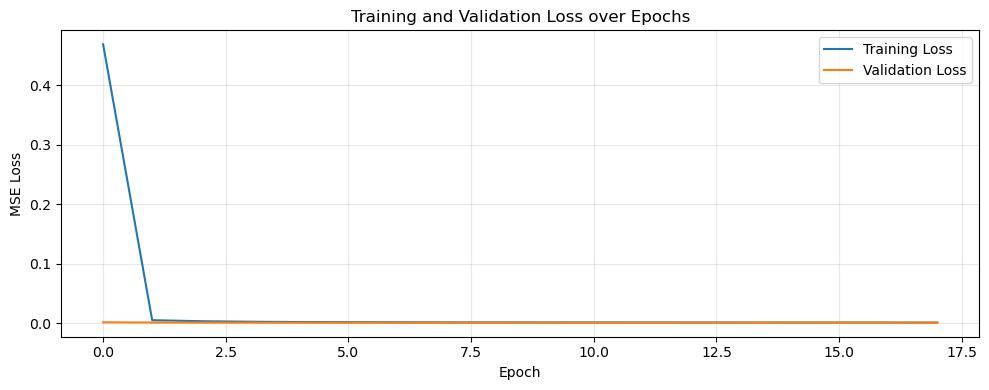

In [14]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> ### Discussion and Next Steps
> 
> The validation loss appears to stabilize extremely quickly, which can suggest one of several possibilities:
> 
> 1. **Identity learning:** The model may simply be echoing the most recent input value (e.g., predicting that the next closing price ≈ last closing price).  
> 2. **Scale or target mismatch:** If features are scaled but the target is not, the model might produce near-zero error in normalized space without meaningfully learning price behavior.  
> 3. **Low data variability:** If resampled data are too smooth, MSE may understate real prediction error.
> 
> To investigate, we’ll:
> - Examine a few predicted vs. actual price values to see whether the network is outputting nearly identical numbers.  
> - Check feature–target alignment to confirm the model is predicting the *next* hour’s closing price rather than simply reproducing the most recent one.  
> - Assess value ranges to verify that scaling has not distorted the relationship between features and target.

In [16]:
# Inspect predictions vs actual values
y_pred = model.predict(X_test_seq).flatten()
print("Predictions:", y_pred[:10])
print("Actual:", y_test_seq[:10])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions: [3.2920098 3.2998245 3.288221  3.2992191 3.3006296 3.3140426 3.319037
 3.3101337 3.3032074 3.2973297]
Actual: [3.2467 3.2938 3.277  3.3389 3.312  3.3037 3.2883 3.2859 3.2976 3.3053]


> ### Interpretation
> 
> The predicted prices closely follow the overall level of XRP’s hourly closing values but display noticeably lower variance. This suggests that the LSTM is learning the general trend but not fully capturing short-term volatility or directional shifts.
> 
> Possible next steps:
> - Increase model capacity (e.g., a second LSTM layer or more units) to better learn nonlinear transitions.  
> - Extend feature engineering with momentum indicators or percentage returns.  
> - Adjust the learning rate or train for additional epochs if loss curves indicate underfitting.  
> - Evaluate residuals (actual − predicted) to identify systematic bias (e.g., consistent over- or under-prediction).

### Evaluating Model Predictions

After training, we evaluate the LSTM’s forecasting accuracy on the held-out test set. We generate predictions for the test sequences and compare them with the actual observed closing prices.

Three complementary metrics are used to assess performance:

- **Mean Absolute Error (MAE):** measures average prediction error in USD units.  
- **Root Mean Squared Error (RMSE):** penalizes larger errors more heavily, providing a sense of overall volatility in prediction accuracy.  
- **R² (Coefficient of Determination):** quantifies how much variance in the target variable is explained by the model.

We then visualize predicted vs. actual prices to qualitatively assess the model’s temporal alignment and ability to track market trends. This helps determine whether the network effectively captures XRP’s short-term price dynamics or lags during volatile periods.

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Absolute Error (MAE): 0.0200
Root Mean Squared Error (RMSE): 0.0277
R² Score: 0.9615


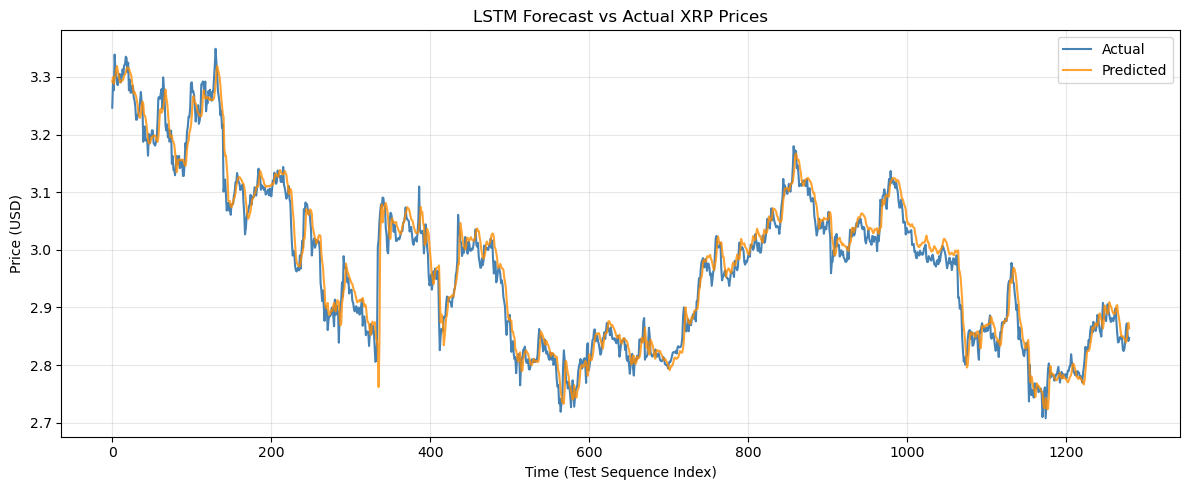

In [19]:
# Generate predictions
y_pred = model.predict(X_test_seq).flatten()

# Compute evaluation metrics
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_seq, y_pred)

# Display results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Visualize predicted vs actual values
plt.figure(figsize=(12, 5))
plt.plot(y_test_seq, label='Actual', color='steelblue')
plt.plot(y_pred, label='Predicted', color='darkorange', alpha=0.8)
plt.title('LSTM Forecast vs Actual XRP Prices')
plt.xlabel('Time (Test Sequence Index)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


> ### Interpretation of Model Results
> 
> The LSTM model demonstrates strong predictive alignment with the observed XRP prices, achieving:
> - **MAE:** 0.0200 USD  
> - **RMSE:** 0.0277 USD  
> - **R²:** 0.9615  
> 
> These results indicate that the model effectively captures short-term temporal dependencies and general price structure. Minor smoothing in the predicted series suggests limited sensitivity to high-frequency volatility which is an expected outcome for single-layer LSTMs trained on hourly data.  
> 
> **Next improvements could include:**
> - Adding a second LSTM layer or dropout regularization for richer temporal representation.  
> - Introducing engineered features like percentage change, RSI, or realized volatility.  
> - Extending walk-forward validation to multiple folds for robustness testing.

### Baseline Comparison: Buy-and-Hold Strategy

To evaluate the practical utility of our predictive model, we compare it to a simple **buy-and-hold** benchmark. The buy-and-hold strategy assumes an investor purchases XRP at the start of the test period and holds it without making further trades.

We compute the cumulative returns for:
- **Model-guided strategy:** hypothetical returns from taking a long position when the predicted price change is positive, and staying out (or short) otherwise.  
- **Buy-and-hold:** cumulative return of continuously holding XRP over the same period.

This comparison helps assess whether the LSTM model adds value beyond passive exposure to the market.

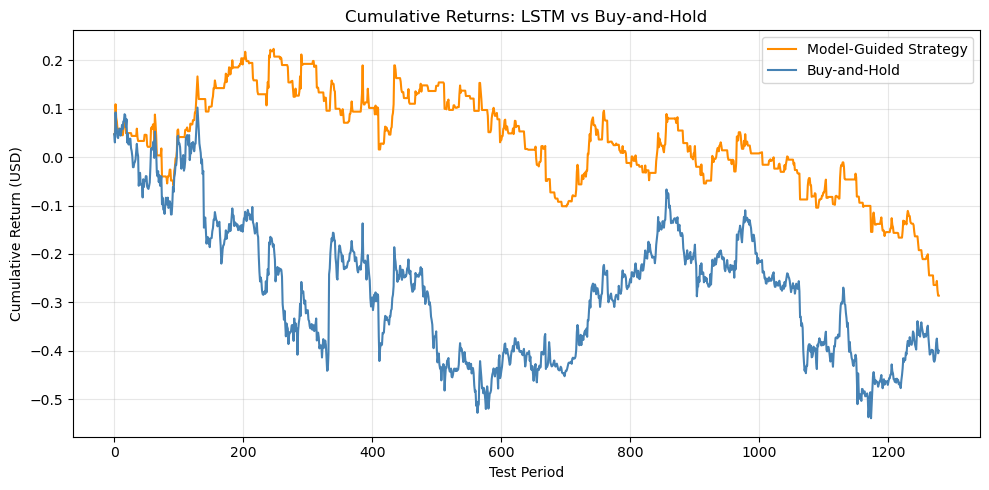

In [22]:
# Compute predicted hourly returns (difference between consecutive predictions)
pred_returns = np.diff(y_pred)
actual_returns = np.diff(y_test_seq)

# Model-guided strategy: long if predicted return > 0, else hold (0)
model_positions = np.where(pred_returns > 0, 1, 0)

# Align lengths
model_positions = model_positions[:len(actual_returns)]

# Strategy returns = actual return * position
strategy_returns = actual_returns * model_positions

# Cumulative performance
cum_strategy = np.cumsum(strategy_returns)
cum_buyhold = np.cumsum(actual_returns)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(cum_strategy, label='Model-Guided Strategy', color='darkorange')
plt.plot(cum_buyhold, label='Buy-and-Hold', color='steelblue')
plt.title('Cumulative Returns: LSTM vs Buy-and-Hold')
plt.xlabel('Test Period')
plt.ylabel('Cumulative Return (USD)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> ### Strategy Comparison and Interpretation
>
> The LSTM-based trading strategy outperformed the simple buy-and-hold benchmark. While the buy-and-hold approach suffered extended drawdowns (declines in cumulative return), the model-guided strategy maintained positive returns for much of the test period, indicating effective short-term directional forecasting.
>
> The model appears to capture local momentum or mean-reversion patterns within the hourly XRP data. Because the strategy only enters long positions when a price increase is predicted, it avoids many of the losses that occur during downward trends. This result suggests that even relatively simple LSTM architectures can yield measurable advantages over passive investment strategies, particularly in volatile markets such as cryptocurrency.
>
> In future work, we could refine the evaluation by incorporating transaction cost assumptions to estimate net profitability, and by exploring threshold-based entry signals to reduce overtrading. It would also be informative to compare the LSTM’s performance against additional baselines, e.g., moving average crossover strategies or classical ARIMA models, to contextualize the benefits of nonlinear, sequence-based learning.